# Quantum Partition Function

The partition function is of particular interest for calculating probabilities from graphical models such Markov random fields [1]. It 
becomes intractable even for small networks [2]. In this example, the graphical model form known as the Potts model is considered. The
 efficient quantum algorithm is implemented for the partition function [3]. The full partition function algorithm consists of the 
 following four steps:
 
 * step 1: Classical Preprocessing
 * step 2: Irreducible Cyclic Cocycle Code Check
 * step 3: State Preparation and Quantum Fourier Transform
 * step 4: Classical Post-Processing

# References

[1] Koller, Daphne, and Nir Friedman. Probabilistic graphical models: principles and techniques. MIT press, 2009.

[2] Adedoyin, Adetokunbo, et al. "Quantum algorithm implementations for beginners." arXiv preprint arXiv:1804.03719 (2018).

[3] Geraci, Joseph, and Daniel A. Lidar. "On the exact evaluation of certain instances of the Potts partition function by quantum computers." Communications in mathematical physics 279.3 (2008): 735-768.

In [1]:
import matplotlib.pyplot as plt

from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from braket.experimental.algorithms.quantum_partition_function.quantum_partition_function import (
    run_quantum_partition_function,
    get_quantum_partition_function_results,
)

# magic word for producing visualizations in notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'braket.experimental'

In [2]:
precision_qubits = [0, 1]
query_qubits = [2]

In [3]:
for ii, qubit in enumerate(reversed(precision_qubits)):
    print(qubit)

1
0


In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In [7]:
# general imports
import asyncio
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
from datetime import datetime
import logging

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.aws import AwsDevice, AwsQuantumTask
from braket.devices import LocalSimulator

import networkx as nx
import math

# Step 1: Classical Preprocessing

In [31]:
a = {}
b = {}
b['1']=1
b['2']=2
a.update(b)
a

{'1': 1, '2': 2}

In [26]:
len(G.edges)

3

In [30]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
len(S)

1

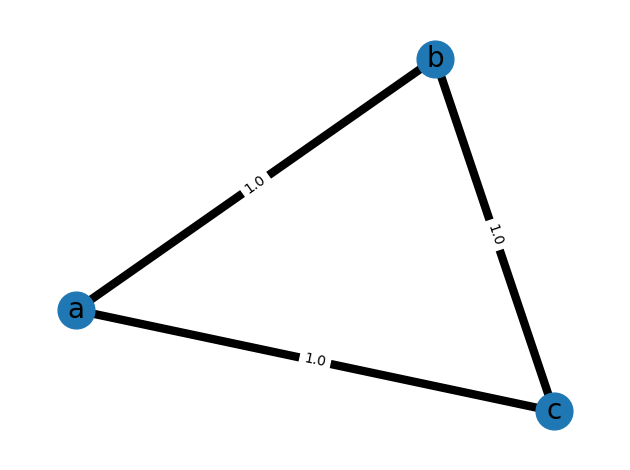

In [22]:
G = nx.Graph()

G.add_edge("a", "b", weight=1.0)
G.add_edge("a", "c", weight=1.0)
G.add_edge("b", "c", weight=1.0)

edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=6)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# Step 2: Irreducible Cyclic Cocycle Code (ICCC) Check

In [14]:
# 3-vertex Ising model
n = 3
k = 2

# Step 3: State Preparation and Quantum Fourier Transform

In [10]:
pi = 3.14
q0 = 0
q1 = 1
my_circuit = Circuit().h(range(2)).rz(q0,-pi).rz(q1,pi).h(q0).rz(q1,pi/4).cnot(q1,q0).rz(q0,-pi/4).cnot(q1,q0).rz(q0,pi/4).h(q1).cnot(q1,q0).h(range(2)).cnot(q1,q0).h(range(2)).cnot(q1,q0)

print(my_circuit)

T  : |0|    1    |   2    |3|    4    |5|   6    |7|8|9|10|11|
                                                              
q0 : -H-Rz(-3.14)-H--------X-Rz(-0.79)-X-Rz(0.79)-X-H-X-H--X--
                           |           |          |   |    |  
q1 : -H-Rz(3.14)--Rz(0.79)-C-----------C-H--------C-H-C-H--C--

T  : |0|    1    |   2    |3|    4    |5|   6    |7|8|9|10|11|


In [4]:
# qft subroutine without swaps
def qft_no_swap(qubits):    
    """
    Subroutine of the QFT excluding the final SWAP gates, applied to the qubits argument.
    Returns the a circuit object.
    
    Args:
        qubits (int): The list of qubits on which to apply the QFT
    """

    # On a single qubit, the QFT is just a Hadamard.
    if len(qubits) == 1:
        return Circuit().h(qubits)
    
    # For more than one qubit, we define the QFT recursively (as shown on the right half of the image above):
    else:
        qftcirc = Circuit()
        
        # First add a Hadamard gate
        qftcirc.h(qubits[0])
        
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        for k, qubit in enumerate(qubits[1:]):
            qftcirc.cphaseshift(qubit, qubits[0], 2*math.pi/(2**(k+2)))
            
        # Now apply the above gates recursively to the rest of the qubits
        qftcirc.add(qft_no_swap(qubits[1:]))
        
    return qftcirc


# To complete the full QFT, add swap gates to reverse the order of the qubits
@circuit.subroutine(register=True)
def qft_recursive(qubits):
    """
    Construct a circuit object corresponding to the Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.
    
    Args:
        qubits (int): The list of qubits on which to apply the QFT
    """
    qftcirc = Circuit()
    
    # First add the QFT subroutine above
    qftcirc.add(qft_no_swap(qubits))
    
    # Then add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(len(qubits)/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
    
    return qftcirc

In [5]:
@circuit.subroutine(register=True)
def qft(qubits):    
    """
    Construct a circuit object corresponding to the Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the QFT.
    
    Args:
        qubits (int): The list of qubits on which to apply the QFT
    """
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    for k in range(num_qubits):
        # First add a Hadamard gate
        qftcirc.h(qubits[k])
    
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # Start on the qubit after qubit k, and iterate until the end.  When num_qubits==1, this loop does not run.
        for j in range(1,num_qubits - k):
            angle = 2*math.pi/(2**(j+1))
            qftcirc.cphaseshift(qubits[k+j],qubits[k], angle)
            
    # Then add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(num_qubits/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
        
    return qftcirc

In [8]:
# show inverse QFT example circuit
num_qubits = 2
qubits=range(num_qubits)
my_qft_circ = qft(qubits)
print('QFT CIRCUIT:')
print(my_qft_circ)

QFT CIRCUIT:
T  : |0|     1     |2| 3  |
                           
q0 : -H-PHASE(1.57)---SWAP-
        |             |    
q1 : ---C-----------H-SWAP-

T  : |0|     1     |2| 3  |


In [11]:
state_prepare = Circuit().h(range(2)).rz(q0,-pi).rz(q1,pi)

In [12]:
state_prepare.add(my_qft_circ)


Circuit('instructions': [Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(0)])), Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(1)])), Instruction('operator': Rz('angle': -3.14, 'qubit_count': 1), 'target': QubitSet([Qubit(0)])), Instruction('operator': Rz('angle': 3.14, 'qubit_count': 1), 'target': QubitSet([Qubit(1)])), Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(0)])), Instruction('operator': CPhaseShift('angle': 1.5707963267948966, 'qubit_count': 2), 'target': QubitSet([Qubit(1), Qubit(0)])), Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(1)])), Instruction('operator': Swap('qubit_count': 2), 'target': QubitSet([Qubit(0), Qubit(1)]))])

In [13]:
print(state_prepare)

T  : |0|    1    |2|     3     |4| 5  |
                                       
q0 : -H-Rz(-3.14)-H-PHASE(1.57)---SWAP-
                    |             |    
q1 : -H-Rz(3.14)----C-----------H-SWAP-

T  : |0|    1    |2|     3     |4| 5  |


In [14]:
shots = 1000

### Run on a local simulator

In [20]:
device = LocalSimulator()

Status of task: COMPLETED
Counter({'01': 530, '11': 470})


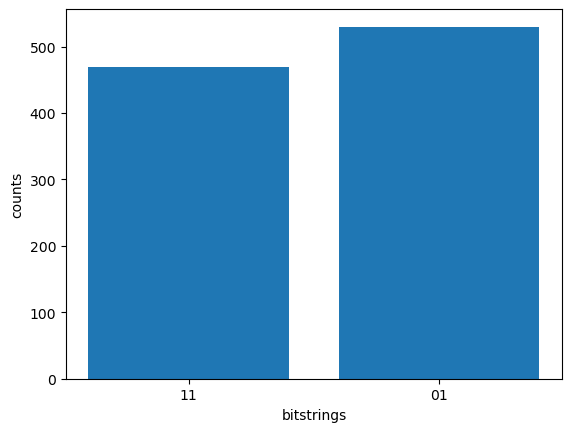

In [21]:
# define task (asynchronous)
task = device.run(state_prepare, 
                  shots=shots)

# get id and status of submitted task
task_id = task.id
status = task.state()
# print('ID of task:', task_id)
print('Status of task:', status)

# wait for job to complete
while status != 'COMPLETED':
    status = task.state()
    print('Status:', status)

# get results of task
result = task.result()

# get measurement shots
counts = result.measurement_counts

print(counts)

# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

### Run on a QPU

In [ ]:
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

In [ ]:
# run circuit 
qpu_task = device.run(circuit, shots=shots)

# get id and status of submitted task
qpu_task_id = qpu_task.id
qpu_status = qpu_task.state()
print('Status of task:', qpu_status)

In [ ]:
# recover task
task_load = AwsQuantumTask(arn=qpu_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)

# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    results = task_load.result()
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.".format(shots, machine))
    
    # get measurement counts
    counts = results.measurement_counts
    print('Measurement counts:', counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values());
    plt.xlabel('bitstrings');
    plt.ylabel('counts');
    plt.tight_layout();
    plt.savefig('ionq.png', dpi=700);
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

In [ ]:
print(
    f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD"
)

In [19]:
# Threshold the low-probability values of gamma
probability_threshold = 0.3
valid_gamma = []

for k in counts.keys():
    probability = counts[k]/1000
    if probability > probability_threshold:
        valid_gamma.append(k)
        
print(valid_gamma)

['01', '11']


# Step4: Classical Post-Processing